In [1]:
!date

Fri Jul  9 16:50:56 PDT 2021


# All clusters DE

In [2]:
!mkdir plots tables

mkdir: cannot create directory ‘plots’: File exists
mkdir: cannot create directory ‘tables’: File exists


In [3]:
import sys

colab = "google.colab" in sys.modules

if colab:
    # download files
    !git clone https://github.com/pachterlab/BYVSTZP_2020.git
    !wget -q -c --show-progress --progress=bar:force -O gene.h5ad.gz https://caltech.box.com/shared/static/2qut50hmb5r2zynd0dkihlj0qpwi6576.gz 2>&1
    !wget -q -c --show-progress --progress=bar:force -O isoform.h5ad.gz https://caltech.box.com/shared/static/7n6n9fvs2737shskqaiamw0dob9rbwva.gz 2>&1
    !gunzip *.gz

    !pip install --quiet anndata

In [4]:
import pandas as pd
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from scipy import stats
import os
import anndata
import matplotlib.transforms as transforms
import matplotlib.patches as mpatches
import glob
import sys
def nd(arr):
    return np.asarray(arr).reshape(-1)

import sys
sys.path.append('BYVSTZP_2020/dexpress')
from dexpress import dexpress, utils, plot


def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [5]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [6]:
num_TSNE = 2
state = 42
metric = "euclidean"
n_neighbors = 30
num_PCA = 25
num_NCA = 10

# Filtering criteria
cell_threshold = 250
disp_threshold = 0.001

mito_criteria = 10

n_top_genes = 5000

n_bins = 20

flavor="seurat"

scale_clip = 10

In [7]:
import ast

In [8]:
gene = anndata.read_h5ad("gene.h5ad")
isoform = anndata.read_h5ad("isoform.h5ad")

In [9]:
isoform = isoform[isoform.obs.eval("subclass_label != 'L5 IT'").values]
gene = gene[gene.obs.eval("subclass_label != 'L5 IT'").values]

09-Jul-21 16:51:05 - Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
09-Jul-21 16:51:05 - NumExpr defaulting to 8 threads.


In [10]:
gene_id = gene.var["gene_id"].values
gene_names = gene.var["gene_name"].values.astype(str)

# Restrict to genes with more than one isoform

In [11]:
gene = gene[:,gene.var["num_isoforms"]>1]

In [12]:
%%time
transcripts = []
l = gene.var.txn_list.values
for sublist in l:
    sublist = ast.literal_eval(sublist)
    for item in sublist:
        transcripts.append(item)

CPU times: user 245 ms, sys: 8.04 ms, total: 253 ms
Wall time: 251 ms


In [13]:
isoform = isoform[:,isoform.var["transcript_id"].isin(transcripts)]

In [14]:
print(gene)
print(isoform)

View of AnnData object with n_obs × n_vars = 4599 × 11891
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts', 'percent_mito', 'n_genes', 'pass_count_filter', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'txn_list', 'num_isoforms', 'gene_counts', 'dispersion', 'pass_disp_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p', 'norm'
    obsp: 'connectivities', 'distances'
View of AnnData object with n_obs × n_vars = 4599 × 61873
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'gene_counts', 'high

In [15]:
isoform = isoform[isoform.obs.sort_values(["cluster_label", "cell_id"]).index]
gene = gene[gene.obs.sort_values(["cluster_label", "cell_id"]).index]

In [16]:
False in (gene.obs.cluster_label == isoform.obs.cluster_label)

False

In [17]:
isoform.obs

,cluster_id,cluster_label,subclass_label,class_label,cluster_color,size,cell_id,subclass_id,class_id,cell_counts,leiden,louvain
112,58,Astro Aqp4,Astro,Non-Neuronal,#7C2D1F,10,LS-15501_S47_E1-50,0,3,985306.8750,7,7
1073,58,Astro Aqp4,Astro,Non-Neuronal,#7C2D1F,10,SM-D9D87_S28_E1-50,0,3,982938.0625,7,7
4464,58,Astro Aqp4,Astro,Non-Neuronal,#7C2D1F,10,SM-DD449_S01_E1-50,0,3,999301.3125,14,4
4991,58,Astro Aqp4,Astro,Non-Neuronal,#7C2D1F,10,SM-GE65I_S103_E1-50,0,3,990256.1875,7,7
4992,58,Astro Aqp4,Astro,Non-Neuronal,#7C2D1F,10,SM-GE65I_S104_E1-50,0,3,987743.6875,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...
6471,6,Vip Serpinf1,Vip,GABAergic,#A720FF,50,SM-GE935_S268_E1-50,17,0,997492.0625,12,12
6532,6,Vip Serpinf1,Vip,GABAergic,#A720FF,50,SM-GE935_S337_E1-50,17,0,998825.7500,12,12
6537,6,Vip Serpinf1,Vip,GABAergic,#A720FF,50,SM-GE935_S342_E1-50,17,0,998837.6875,5,12
6545,6,Vip Serpinf1,Vip,GABAergic,#A720FF,50,SM-GE935_S350_E1-50,17,0,998223.1250,12,12


# determine the isoforms

In [18]:
def violinplot(data, ax, **kwd): 
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    color = kwd.get("color", "#D43F3A")
    
    if  len(xticks)==0: xticks = np.arange(len(data))+1;
    if  len(xticklabels)==0: xticklabels = np.arange(len(data))+1;
    assert(len(xticks) == len(xticklabels))
        
    violins = ax.violinplot(data, positions=xticks, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor(color)
        v.set_edgecolor('black')
        v.set_alpha(1)
    
    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 2, color="grey")
        
        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean,color="black")    
        ax.vlines(x, mean - stdev, mean+stdev, color='black', linestyle='-', lw=2)
    
    return ax


# do for all clusters with a certain number of cells per cluster

In [19]:
subclasses = np.sort(isoform.obs.subclass_label.unique())

subclasses = np.setdiff1d(subclasses, ["L5 IT", "Low Quality"]) 

In [20]:
isoform.obs.groupby("subclass_label")["cluster_label"].value_counts()

subclass_label  cluster_label    
Astro           Astro Aqp4             9
Endo            Endo Slc38a5           7
L2/3 IT         L2/3 IT S100a6       231
                L2/3 IT Macc1        128
                L2/3 IT Cdh13 Sla    123
L5 PT           L5 PT                 12
L5/6 NP         L5 NP Slc17a8        136
                L6 NP Trh             71
L6 CT           L6 CT Grp_1          781
                L6 CT Nxph2_1         68
                L6 CT Grp_2           24
                L6 CT Gpr139          21
                L6 CT Nxph2_2         10
L6 IT           L6 IT Sulf_3         271
                L6 IT Sulf_1          68
                L6 IT Sulf_2          56
L6 IT Car3      L6 IT Car3             5
L6b             L6b Rprm             144
                L6b Shisa6           142
                L6b Ror1_2           129
                L6b Ror1_1           115
                L6b Kcnip1_1          32
                L6b Kcnip1_2           8
Lamp5           Lamp5 S

In [21]:
%%time
n_cells = 5

de_clusters = []
de_genes = []
de_isoforms = []
for cidx, c in enumerate(subclasses):
    print(f"{cidx+1} of {len(subclasses)}: {c}")
    tmp_isoform = isoform[isoform.obs.eval(f"subclass_label == '{c}'")].copy()
    tmp_gene    = gene[gene.obs.eval(f"subclass_label == '{c}'")].copy()

    if tmp_isoform.shape[0] >= n_cells: # cluster must have at least 20 cells
        if tmp_isoform.obs.cluster_label.nunique()>1:
            de_clusters.append(c)

            ####### Genes
            mat           = tmp_gene.layers["log1p"].todense()
            components    = tmp_gene.obs.cell_id.values
            features      = tmp_gene.var.gene_name.values
            assignments   = tmp_gene.obs.cluster_label.values

            # parameters
            unique        = np.unique(assignments)
            nan_cutoff    = 0.9 # of elements in cluster
            corr_method   = "bonferroni"

            p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
            p_corr = utils.correct_pvals(p_raw)#, nfeat, corr_method)

            s = stat

            markers_gene = dexpress.make_table(assignments, features, p_raw, p_corr, es)

            # convert the 0 pvalues to the smallest possible float
            markers_gene["p_corr"][markers_gene.eval("p_corr == 0").values] = sys.float_info.min
            markers_gene["n_isoforms"] = markers_gene.name.map(gene.var.num_isoforms)
            de_genes.append(markers_gene)



            ######### Isoforms
            mat           = tmp_isoform.layers["log1p"].todense()
            components    = tmp_isoform.obs.cell_id.values
            features      = tmp_isoform.var.transcript_name.values
            assignments   = tmp_isoform.obs.cluster_label.values

            # parameters
            unique        = np.unique(assignments)
            nan_cutoff    = 0.9 # of elements in cluster
            corr_method   = "bonferroni"


            p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
            p_corr = utils.correct_pvals(p_raw)#, nfeat, corr_method)

            s = stat

            markers_isoform = dexpress.make_table(assignments, features, p_raw, p_corr, es)

            # convert the 0 pvalues to the smallest possible float
            markers_isoform["p_corr"][markers_isoform.eval("p_corr == 0").values] = sys.float_info.min
            de_isoforms.append(markers_isoform)

1 of 16: Astro
2 of 16: Endo
3 of 16: L2/3 IT


09-Jul-21 16:51:08 - 1 of 3 assignments: L2/3 IT Cdh13 Sla
09-Jul-21 16:51:08 - 2 of 3 assignments: L2/3 IT Macc1
09-Jul-21 16:51:08 - 3 of 3 assignments: L2/3 IT S100a6
09-Jul-21 16:51:08 - 1 of 3 assignments: L2/3 IT Cdh13 Sla
09-Jul-21 16:51:08 - 2 of 3 assignments: L2/3 IT Macc1
09-Jul-21 16:51:08 - 3 of 3 assignments: L2/3 IT S100a6


4 of 16: L5 PT
5 of 16: L5/6 NP


09-Jul-21 16:51:10 - 1 of 2 assignments: L5 NP Slc17a8
09-Jul-21 16:51:10 - 2 of 2 assignments: L6 NP Trh
09-Jul-21 16:51:10 - 1 of 2 assignments: L5 NP Slc17a8
09-Jul-21 16:51:10 - 2 of 2 assignments: L6 NP Trh


6 of 16: L6 CT


09-Jul-21 16:51:13 - 1 of 5 assignments: L6 CT Gpr139
09-Jul-21 16:51:13 - 2 of 5 assignments: L6 CT Grp_1
09-Jul-21 16:51:14 - 3 of 5 assignments: L6 CT Grp_2
09-Jul-21 16:51:14 - 4 of 5 assignments: L6 CT Nxph2_1
09-Jul-21 16:51:14 - 5 of 5 assignments: L6 CT Nxph2_2
09-Jul-21 16:51:14 - 1 of 5 assignments: L6 CT Gpr139
09-Jul-21 16:51:15 - 2 of 5 assignments: L6 CT Grp_1
09-Jul-21 16:51:15 - 3 of 5 assignments: L6 CT Grp_2
09-Jul-21 16:51:16 - 4 of 5 assignments: L6 CT Nxph2_1
09-Jul-21 16:51:16 - 5 of 5 assignments: L6 CT Nxph2_2


7 of 16: L6 IT


09-Jul-21 16:51:18 - 1 of 3 assignments: L6 IT Sulf_1
09-Jul-21 16:51:18 - 2 of 3 assignments: L6 IT Sulf_2
09-Jul-21 16:51:18 - 3 of 3 assignments: L6 IT Sulf_3
09-Jul-21 16:51:19 - 1 of 3 assignments: L6 IT Sulf_1
09-Jul-21 16:51:19 - 2 of 3 assignments: L6 IT Sulf_2
09-Jul-21 16:51:19 - 3 of 3 assignments: L6 IT Sulf_3


8 of 16: L6 IT Car3
9 of 16: L6b


09-Jul-21 16:51:21 - 1 of 6 assignments: L6b Kcnip1_1
09-Jul-21 16:51:21 - 2 of 6 assignments: L6b Kcnip1_2
09-Jul-21 16:51:22 - 3 of 6 assignments: L6b Ror1_1
09-Jul-21 16:51:22 - 4 of 6 assignments: L6b Ror1_2
09-Jul-21 16:51:22 - 5 of 6 assignments: L6b Rprm
09-Jul-21 16:51:22 - 6 of 6 assignments: L6b Shisa6
09-Jul-21 16:51:22 - 1 of 6 assignments: L6b Kcnip1_1
09-Jul-21 16:51:22 - 2 of 6 assignments: L6b Kcnip1_2
09-Jul-21 16:51:23 - 3 of 6 assignments: L6b Ror1_1
09-Jul-21 16:51:23 - 4 of 6 assignments: L6b Ror1_2
09-Jul-21 16:51:23 - 5 of 6 assignments: L6b Rprm
09-Jul-21 16:51:23 - 6 of 6 assignments: L6b Shisa6


10 of 16: Lamp5


09-Jul-21 16:51:25 - 1 of 5 assignments: Lamp5 Egln3_1
09-Jul-21 16:51:25 - 2 of 5 assignments: Lamp5 Egln3_2
09-Jul-21 16:51:25 - 3 of 5 assignments: Lamp5 Lhx6
09-Jul-21 16:51:25 - 4 of 5 assignments: Lamp5 Pdlim5
09-Jul-21 16:51:25 - 5 of 5 assignments: Lamp5 Slc35d3
09-Jul-21 16:51:26 - 1 of 5 assignments: Lamp5 Egln3_1
09-Jul-21 16:51:26 - 2 of 5 assignments: Lamp5 Egln3_2
09-Jul-21 16:51:26 - 3 of 5 assignments: Lamp5 Lhx6
09-Jul-21 16:51:26 - 4 of 5 assignments: Lamp5 Pdlim5
09-Jul-21 16:51:26 - 5 of 5 assignments: Lamp5 Slc35d3


11 of 16: Pvalb


09-Jul-21 16:51:28 - 1 of 5 assignments: Pvalb Calb1
09-Jul-21 16:51:28 - 2 of 5 assignments: Pvalb Gpr149
09-Jul-21 16:51:28 - 3 of 5 assignments: Pvalb Reln
09-Jul-21 16:51:28 - 4 of 5 assignments: Pvalb Th
09-Jul-21 16:51:28 - 5 of 5 assignments: Pvalb Vipr2
09-Jul-21 16:51:28 - 1 of 5 assignments: Pvalb Calb1
09-Jul-21 16:51:29 - 2 of 5 assignments: Pvalb Gpr149
09-Jul-21 16:51:29 - 3 of 5 assignments: Pvalb Reln
09-Jul-21 16:51:29 - 4 of 5 assignments: Pvalb Th
09-Jul-21 16:51:29 - 5 of 5 assignments: Pvalb Vipr2


12 of 16: SMC
13 of 16: Sncg


09-Jul-21 16:51:30 - 1 of 2 assignments: Sncg
09-Jul-21 16:51:30 - 2 of 2 assignments: Sncg Slc17a8
09-Jul-21 16:51:30 - 1 of 2 assignments: Sncg
09-Jul-21 16:51:30 - 2 of 2 assignments: Sncg Slc17a8


14 of 16: Sst


09-Jul-21 16:51:32 - 1 of 7 assignments: Sst C1ql3
09-Jul-21 16:51:32 - 2 of 7 assignments: Sst Chodl
09-Jul-21 16:51:32 - 3 of 7 assignments: Sst Crhr2_1
09-Jul-21 16:51:32 - 4 of 7 assignments: Sst Crhr2_2
09-Jul-21 16:51:32 - 5 of 7 assignments: Sst Etv1
09-Jul-21 16:51:32 - 6 of 7 assignments: Sst Myh8_1
09-Jul-21 16:51:32 - 7 of 7 assignments: Sst Myh8_2
09-Jul-21 16:51:32 - 1 of 7 assignments: Sst C1ql3
09-Jul-21 16:51:32 - 2 of 7 assignments: Sst Chodl
09-Jul-21 16:51:33 - 3 of 7 assignments: Sst Crhr2_1
09-Jul-21 16:51:33 - 4 of 7 assignments: Sst Crhr2_2
09-Jul-21 16:51:33 - 5 of 7 assignments: Sst Etv1
09-Jul-21 16:51:33 - 6 of 7 assignments: Sst Myh8_1
09-Jul-21 16:51:33 - 7 of 7 assignments: Sst Myh8_2


15 of 16: VLMC
16 of 16: Vip


09-Jul-21 16:51:36 - 1 of 10 assignments: Vip C1ql1
09-Jul-21 16:51:36 - 2 of 10 assignments: Vip Chat_1
09-Jul-21 16:51:36 - 3 of 10 assignments: Vip Chat_2
09-Jul-21 16:51:36 - 4 of 10 assignments: Vip Chat_3
09-Jul-21 16:51:36 - 5 of 10 assignments: Vip Crispld2
09-Jul-21 16:51:36 - 6 of 10 assignments: Vip Gpc3
09-Jul-21 16:51:36 - 7 of 10 assignments: Vip Htr1f
09-Jul-21 16:51:36 - 8 of 10 assignments: Vip Igfbp6
09-Jul-21 16:51:36 - 9 of 10 assignments: Vip Lmo1
09-Jul-21 16:51:36 - 10 of 10 assignments: Vip Serpinf1
09-Jul-21 16:51:36 - 1 of 10 assignments: Vip C1ql1
09-Jul-21 16:51:37 - 2 of 10 assignments: Vip Chat_1
09-Jul-21 16:51:37 - 3 of 10 assignments: Vip Chat_2
09-Jul-21 16:51:37 - 4 of 10 assignments: Vip Chat_3
09-Jul-21 16:51:37 - 5 of 10 assignments: Vip Crispld2
09-Jul-21 16:51:38 - 6 of 10 assignments: Vip Gpc3
09-Jul-21 16:51:38 - 7 of 10 assignments: Vip Htr1f
09-Jul-21 16:51:38 - 8 of 10 assignments: Vip Igfbp6
09-Jul-21 16:51:38 - 9 of 10 assignments: Vip Lmo

CPU times: user 22.6 s, sys: 11.3 s, total: 33.9 s
Wall time: 33.8 s


In [22]:
markers_gene = pd.concat(de_genes)

markers_isoform = pd.concat(de_isoforms)

markers_isoform["index"].nunique()

markers_isoform = markers_isoform.query('es>0')
markers_gene = markers_gene.query('es>0')

# Make the two tables, hidden by gene and not hidden by gene

In [23]:
alpha =0.01
fc = 2

relevant_genes = markers_gene.p_corr < alpha

markers_gene["index_name"] = markers_gene["index"] + "_" + markers_gene.name.apply(lambda x: "".join(x.split("_")[:-1]))
markers_isoform["index_name"] = markers_isoform["index"] + "_" + markers_isoform.name.apply(lambda x: "-".join(x.split("-")[:-1]))

setdiff = np.setdiff1d(markers_isoform["index_name"].values, markers_gene[relevant_genes]["index_name"].values)

In [24]:
markers_isoform_hidden = markers_isoform[markers_isoform["index_name"].isin(setdiff)].sort_values(["es", "p_corr"])

markers_isoform_hidden = markers_isoform_hidden.query(f"p_corr < {alpha}")

In [25]:
alpha = 0.01
markers_gene = markers_gene.query(f"p_corr < {alpha}")
markers_isoform = markers_isoform.query(f"p_corr < {alpha}")

In [26]:
# write isoform_only
markers_isoform.to_csv("tables/all_clusters_DE_isoform_only.csv")
markers_isoform_hidden.to_csv("tables/all_clusters_DE.csv")

In [27]:
markers_isoform.groupby("index")["name"].nunique().sum()

0

In [28]:
markers_isoform_hidden.groupby("index")["name"].nunique().sum()

0

In [29]:
identified_isoforms = markers_isoform_hidden["name"].drop_duplicates(keep='first')

identified_genes = identified_isoforms.apply(lambda x: x.split("-")[0:-1][0])

print("{} isoforms from {} genes identified.".format(identified_isoforms.shape[0], identified_genes.nunique()))

0 isoforms from 0 genes identified.


In [30]:
identified_isoforms = markers_isoform["name"].drop_duplicates(keep='first')

identified_genes = identified_isoforms.apply(lambda x: x.split("-")[0:-1][0])

print("{} isoforms from {} genes identified.".format(identified_isoforms.shape[0], identified_genes.nunique()))

0 isoforms from 0 genes identified.


In [31]:
markers_isoform.groupby("index")["name"].nunique().shape

(0,)

# Visualize a hidden one

In [32]:
isoform.obs.subclass_label.value_counts()

L6 CT          904
Vip            607
L6b            570
Pvalb          521
L2/3 IT        482
Sst            406
L6 IT          395
Lamp5          360
L5/6 NP        207
Sncg            77
SMC             19
L5 PT           12
Low Quality     12
Astro            9
Endo             7
VLMC             6
L6 IT Car3       5
Name: subclass_label, dtype: int64

In [33]:
markers_isoform_hidden.sort_values(["p_corr", "es"]).head(10)

,index,name,p_raw,p_corr,es,index_name


In [34]:
specific_cluster = "L6b Ror1_1"
specific_isoform = "Stxbp2-207_ENSMUST00000160708"
specific_gene = "".join(specific_isoform.split("-")[:-1])
subclass = " ".join(specific_cluster.split(" ")[:-1])

In [35]:
subclass

'L6b'

In [36]:
isoform_f = isoform[isoform.obs.eval(f"subclass_label == '{subclass}'")]
gene_f = gene[gene.obs.eval(f"subclass_label == '{subclass}'")]

In [37]:
gene_f.var[gene_f.var.gene_name.str.contains(specific_gene+"_")].gene_name.values

array(['Stxbp2_ENSMUSG00000004626'], dtype=object)

In [38]:
specific_gene = gene_f.var[gene_f.var.gene_name.str.contains(specific_gene+"_")].gene_name.values[0]

In [39]:
def violinplot(data, ax, **kwd): 
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    selected = kwd.get("selected", None)
    color = kwd.get("color", "grey")
    
    if  len(xticks)==0: xticks = np.arange(len(data))+1;
    if  len(xticklabels)==0: xticklabels = np.arange(len(data))+1;
    assert(len(xticks) == len(xticklabels))
        
    violins = ax.violinplot(data, positions=xticks, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor(color)
        v.set_edgecolor('black')
        v.set_alpha(1)
        if selected == vidx:
            v.set_facecolor("#D43F3A")

            
    
    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 5, color="white", edgecolor="black", linewidth=1)
        
        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean, color="lightgrey", edgecolor="black", linewidth=1, zorder=10)    
        ax.vlines(x, mean - stdev, mean+stdev, color='lightgrey', linestyle='-', lw=2, zorder=9)
        
    ax.set(**{"xticks": xticks, "xticklabels":xticklabels})
    
    return ax


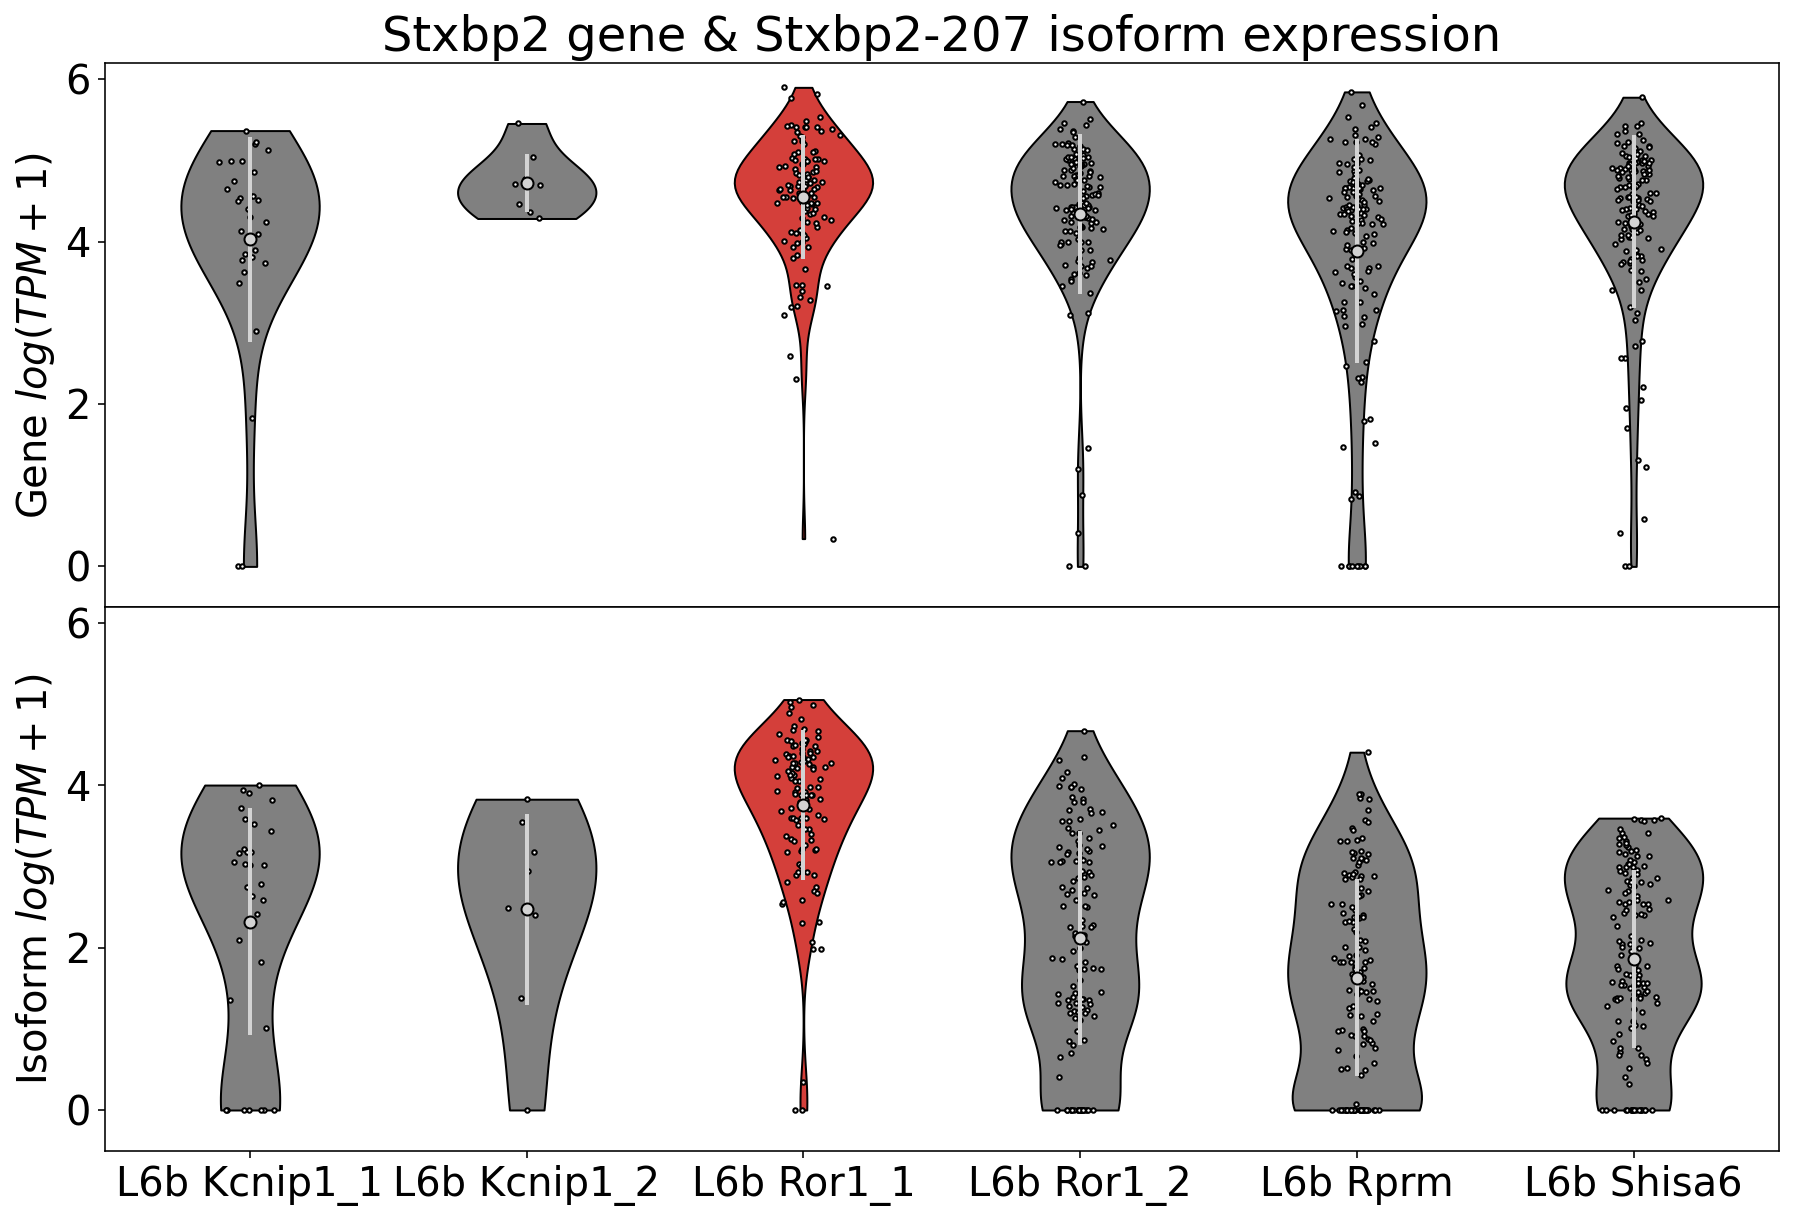

In [40]:
fig, ax = plt.subplots(figsize=(15,10), nrows=2, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

# Declare
unique = np.unique(gene_f.obs.cluster_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))
labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]

## Plot
# Gene
x = []
for c in unique:
    x.append(np.asarray(gene_f[gene_f.obs.cluster_label==c][:,gene_f.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())
violinplot(x, ax[0], selected=midx)

# Isoform
x = []
for c in unique:
    x.append(np.asarray(isoform_f[isoform_f.obs.cluster_label==c][:,isoform_f.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1).tolist())
violinplot(x, ax[1], selected=midx, xticks=lidx, xticklabels=labels)


## Style
ax[0].set(**{
    "title":"{} gene & {} isoform expression".format(specific_gene.split("_")[0], specific_isoform.split("_")[0]),
    "ylabel":"Gene $log(TPM + 1)$",
    "ylim": -0.5
})
ymin, ymax = ax[0].get_ylim()
ax[1].set(**{
    "ylabel":"Isoform $log(TPM + 1)$",
    "ylim": (ymin, ymax),
})


plt.savefig("plots/cluster_DE_violin_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

In [41]:
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from matplotlib import cm

In [42]:
num_NCA = 5
state = 42
num_PCA = 10
num_TSNE = 2
metric = "euclidean"

In [43]:
X = gene_f.X

tsvd = TruncatedSVD(n_components=num_PCA)
Y = tsvd.fit_transform(X)

In [44]:
# NCA
X = Y
y = gene_f.obs.cluster_id.values.astype(int)

nca = NeighborhoodComponentsAnalysis(n_components=num_NCA,random_state=state)
YY = nca.fit_transform(X, y)

In [45]:
tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
YYY = tsne.fit_transform(YY)

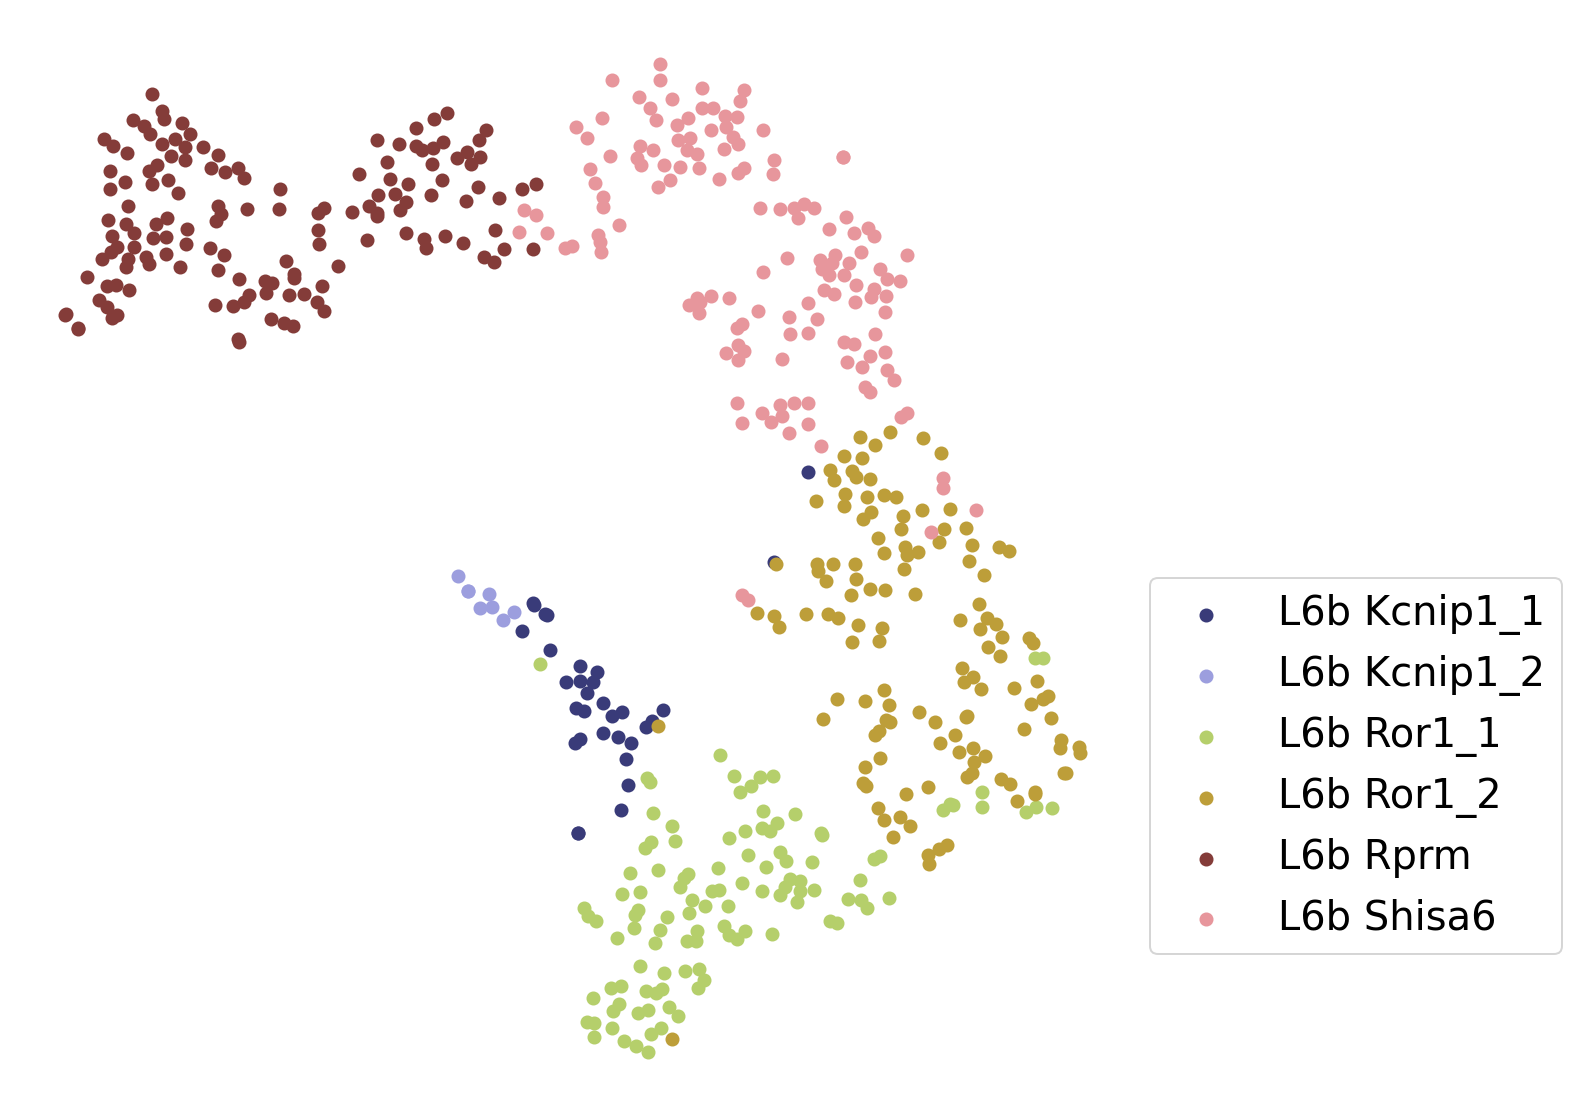

In [46]:
fig, ax = plt.subplots(figsize=(10,10))

x = YYY[:,0]
y = YYY[:,1]
c = cm.get_cmap("tab20b")
assignments = gene_f.obs.cluster_label.values
unique = np.unique(assignments)

for uidx, u in enumerate(unique):
    mask = assignments==u
    xx = x[mask]
    yy = y[mask]
    ax.scatter(xx, yy, color=c(uidx*3), cmap="tab20b", label=u)


ax.legend(bbox_to_anchor=(1, 0.5))

ax.set_axis_off()
plt.show()

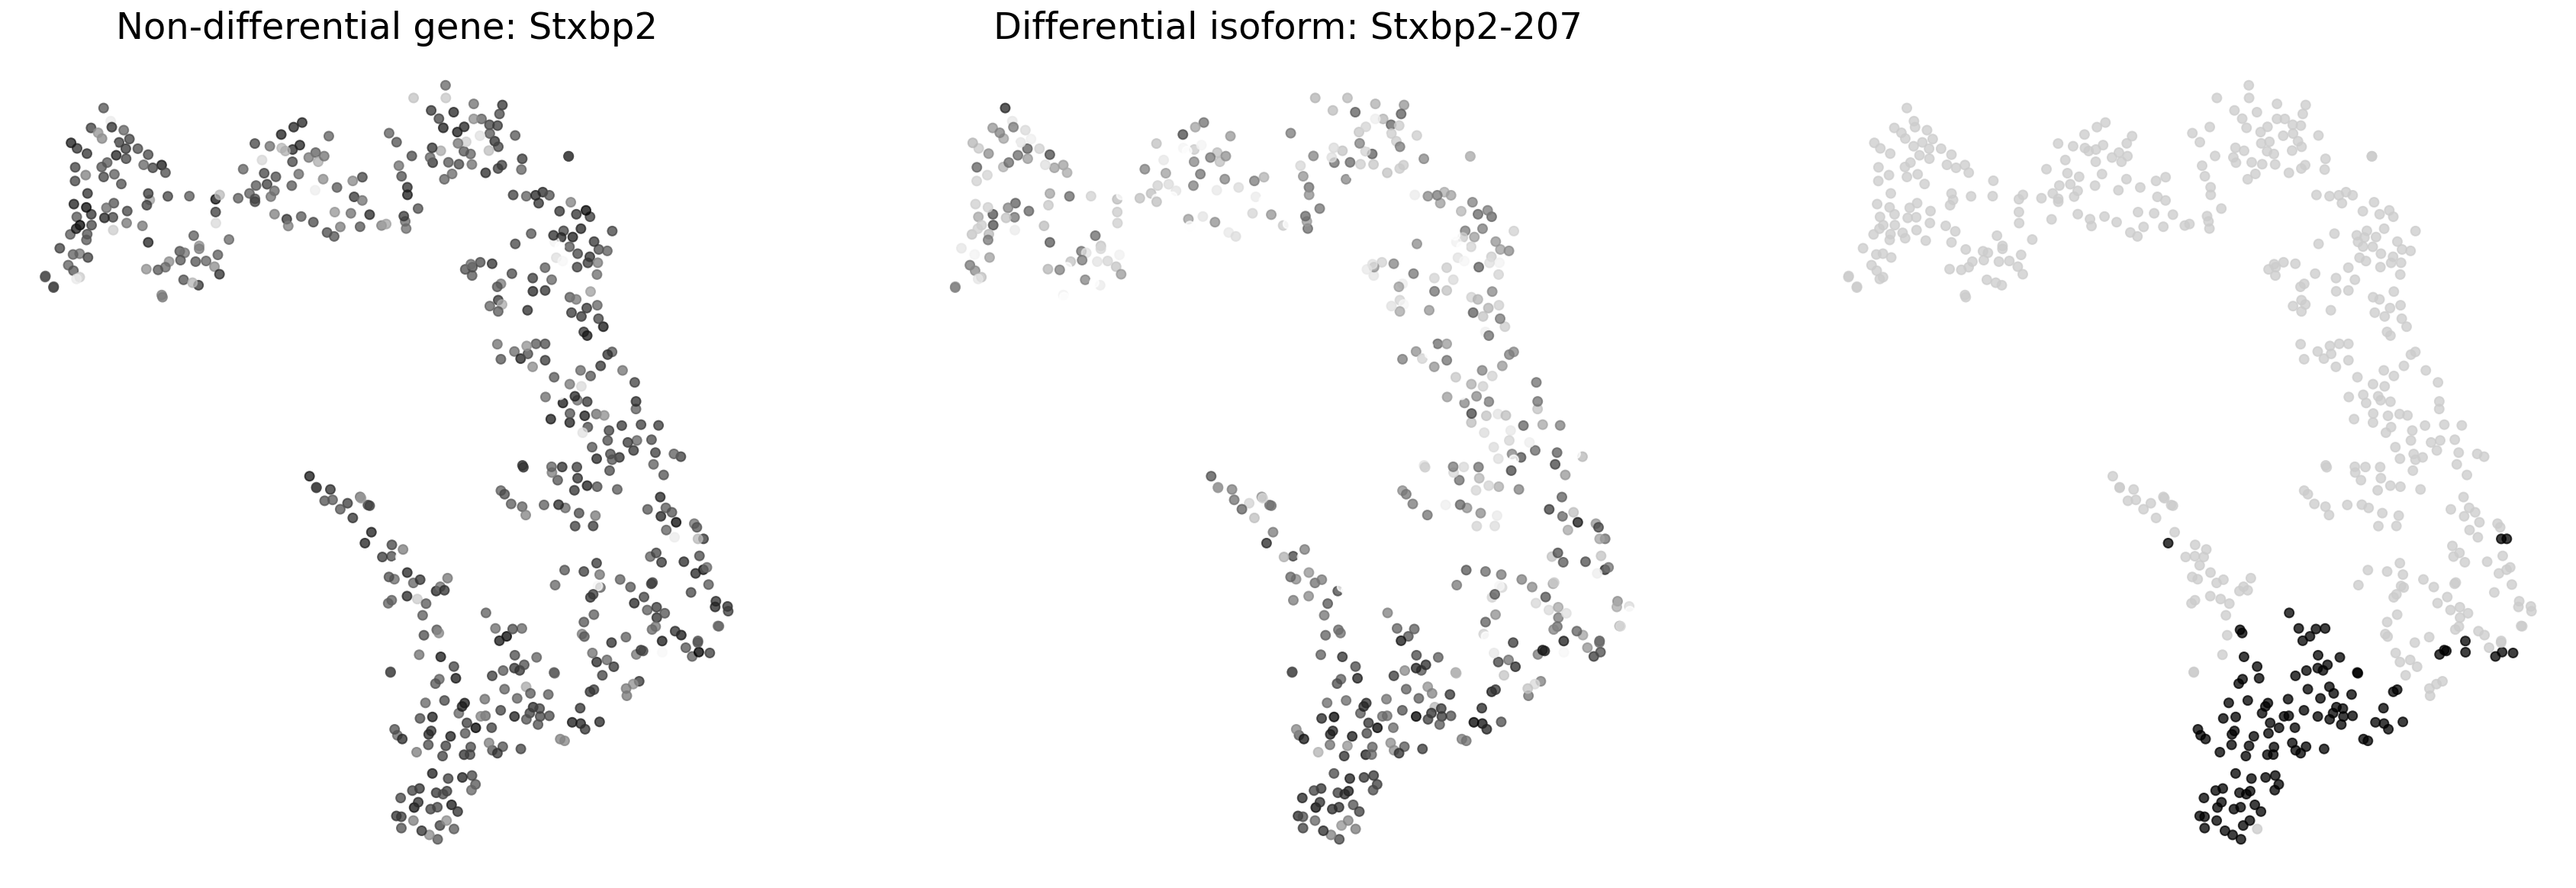

In [47]:
complement_color = (0.8, 0.8, 0.8, 1.0)

fig, ax = plt.subplots(figsize=(30,10), ncols=3)

x = YYY[:,0]
y = YYY[:,1]
c = np.asarray(gene_f[:, gene_f.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1)
cmap="Greys"
alpha = 0.75
ax[0].set_title("Non-differential gene: {}".format(specific_gene.split("_")[0]))

ax[0].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[0].set_axis_off()


x = YYY[:,0]
y = YYY[:,1]
c = np.asarray(isoform_f[:, isoform_f.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
cmap="Greys"
alpha = 0.75
ax[1].set_title("Differential isoform: {}".format(specific_isoform.split("_")[0]))

ax[1].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[1].set_axis_off()

x = YYY[:,0]
y = YYY[:,1]

c = gene_f.obs["cluster_id"].values.astype(int)
c = gene_f.obs["cluster_label"]==specific_cluster

alpha=0.75
cmap="nipy_spectral_r"

ax[2].scatter(x, y, c=c, cmap=cmap, alpha=alpha)

ax[2].set_axis_off()
#ax[2].set_title("Cluster: {}".format(specific_cluster))
plt.savefig("plots/cluster_DE_nca_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()